## Multi Layer Perceptron

MLP with configurable number of (dense) hidden layers and final softmax layer 

The propagation and backpropagation is implemented "from scratch" using numpy

For debbuging purposes you may want to choose MNIST light. Set $mnist = 0$ in cell [2]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds 
from sklearn import model_selection as ms

#get local download folder where data is stored
#you may change this in the call fetch_openml() below
data_h = ds.get_data_home()
print(data_h)

####### Added to select weight initialization in dense layer ########
init_mode = 1 #1,2,3
##############

/home/quentin/scikit_learn_data


In [2]:
#choose 0 to work with mnist light (simpler for debugging) 
mnist_flag = 1

if mnist_flag == 1:
    # the first time this will download the data from the internet and put to a local folder 
    mnist = ds.fetch_openml(name='mnist_784')

    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist))
    # show the keys of digit
    print(mnist.keys())
    # get data i.e. the image (x) and labels (y)
    x = np.array(mnist['data'])
    # as compare to the in class activity we convert the labels here to int
    y = np.array(mnist['target'], dtype='int')
    #set image width
    img_width = 28
else:
    mnist_light = ds.load_digits()
    # digit is a "bunch" i.e. similar to a dictionary
    print(type(mnist_light))
    # show the keys of digit
    print(mnist_light.keys())
    # get data i.e. the image (x) and labels (y)
    x = mnist_light['data']
    y = mnist_light.target
    #set image width
    img_width = 8
    
# get the respective shape
print("x shape:", x.shape)
print("y shape:", y.shape)

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
x shape: (70000, 784)
y shape: (70000,)


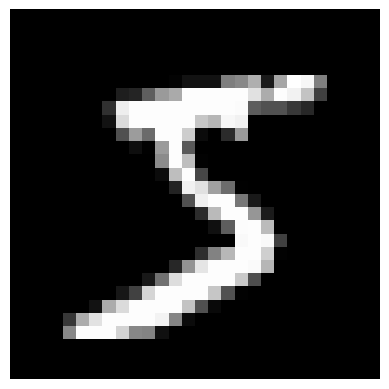

In [3]:
def plot_img(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()
    
    
img = x[0,:].reshape((img_width,img_width))
plot_img(img)

In [4]:
def plot_tiles(x_array, rows, cols = -1, digit_size = 28, fig_size = [10,10]):
    """
    plot list of mnist images as single image

    Arguments:
    x_array -- array of mnist images (being organised as ROWS!)
    rows/cols -- an image of rows x cols - mnist images is created (if x_array is smaller zeros ared padded)
    digit_size -- width (= height) of one single digit (= 8 for MNIST light, = 28 for MINIST)
    fig_size -- size of full image created (default [10,10])
    """
    #use rows = cols as default
    if cols < 0:
        cols = rows
        
    if x_array.shape[0] < rows*cols:
        cols = int(x_array.shape[0]/rows)
        remain = np.mod(x_array.shape[0], rows)
        if 0 < remain:
            cols += 1
            x_array = np.append(x_array, np.zeros((rows-remain, x_array.shape[1])), 0)    
        
    img = x_array[0:rows,:].reshape(rows*digit_size,digit_size)
    for i0 in range(1,cols):
        #the reshape operator in the append call takes num of digit_size x digit_size images and 
        #puts them in a single column; append then does the rest
        img = np.append(img, x_array[i0*rows:(i0+1)*rows,:].reshape(rows*digit_size,digit_size),1)

    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    ax.set_axis_off()

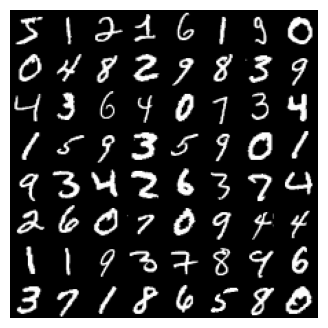

In [5]:
#append rows x cols tiles of digits
rows = 8
cols = 8
#figure size can be set
fig_size = [4,4]

plot_tiles(x, rows, cols, img_width, fig_size)

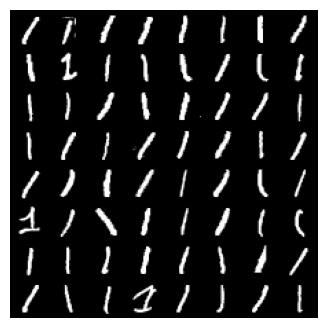

In [6]:
#choose a given digit 0..9
digit  = 1

plot_tiles(x[y == digit,:], rows, cols, img_width, fig_size)

In [7]:
#select training and test set (random_state sets the seed for reproducible results)

from sklearn import model_selection as ms

#define train and test split
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, 
                                     test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(59500, 784) (10500, 784) (59500,) (10500,)


In [8]:
#perform normalisation

xmax, xmin = np.max(x_train), np.min(x_train)
x_train = 2*(x_train - xmin) / (xmax - xmin) - 1
x_test = 2*(x_test - xmin) / (xmax - xmin) - 1

In [9]:
class MiniBatches:
    """
    obtains x- and y-data in the constructor and returns a sample of batch_size with each call to next()
    """
    def __init__(self, x, y, batch_size):
        """
        constructor

        Arguments:
        x/y -- data
        batch_size -- size of batch (0 means one single batch)
        """
        self.x = x
        self.y = y
        m = x.shape[0]
        self.indices = np.arange(m)
        self.n = x.shape[1]
        
        if not batch_size:
            self.batch_size = m
            self.mb = 1
        else:
            self.batch_size = batch_size        
            self.mb = int(m / self.batch_size)    
            np.random.shuffle(self.indices)
        
        self.ib = 0

    def number_of_batches(self):
        return self.mb

    def next(self):
        it = self.indices[self.ib * self.batch_size:(self.ib + 1) * self.batch_size]
        x_batch = self.x[it, :]
        y_batch = self.y[it]
        self.ib += 1

        return {'x_batch': x_batch, 'y_batch': y_batch}


### Batch Normalization Layer

Implementation of class for batch normalization layer (to be put after dense layer). This class is used by the class MultiLayerPerceptron below.


In [67]:
class BatchNormLayer:
    """
    constructs a batch normalization layer for a MLP
    """
    def __init__(self, num_in, num_out, eps = 1.0e-3):
        """
        constructor

        Arguments:
        num_in -- number of inputs (i.e. of neurons from previous layer)
        num_out -- number of outputs (parameter is ignored and set equal to num_in) 
        eps -- small number use to avoid division by zero (reduced for tests)
        """
        
        self.num_in = num_in
        self.num_out = num_in
        
        #average values of mu and sigma used for inference
        self.sigma_avg = np.ones((1, num_in))
        self.mu_avg = np.zeros((1, num_in))
        
        #parameters gamma and beta trained during back propagation
        self.gamma = np.ones((1, num_in))
        self.beta = np.zeros((1, num_in))
        
        self.eps = eps
        
        self.init = True
        
    def propagate(self, a_in, learn = False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        
        Arguments:
        learn -- set to True during learning
        """
        
        if learn:
            #in case we are learning      
            self.num_samples = a_in.shape[0] #may change in different steps
            
            ### START YOUR CODE ###
            mu = np.array([np.mean(a_in, axis=0)])
            self.sigma = np.array([np.sqrt(np.var(a_in, axis=0) + self.eps)])
            self.a_in_scal = (a_in - mu) / self.sigma
            ### END YOUR CODE ###    
            
            #determine average values of mu and sigma
            if self.init == True:
                #first training step
                self.mu_avg = mu
                self.sigma_avg = self.sigma
                self.init = False
            else:
                beta = 0.9
                self.mu_avg = beta*self.mu_avg + (1 - beta) * mu
                self.sigma_avg = beta*self.sigma_avg + (1 - beta) * self.sigma
                
        else:
            #for inference we scale inputs with average values of mu and sigma
            self.a_in_scal = (a_in - self.mu_avg) / (self.eps + self.sigma_avg)
          
        #rescaling of the activations with gamma and beta
        self.a_out = self.gamma * self.a_in_scal + self.beta

        return self.a_out
            
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """        
        ### START YOUR CODE ###
        #derivatives wrt gamma and beta
        m = dL_da_out.shape[0]
        self.dL_dgamma = (1 / m) * np.sum(dL_da_out * self.a_in_scal, axis=0, keepdims=True)
        self.dL_dbeta = (1 / m) * np.sum(dL_da_out, axis=0, keepdims=True)

        dL_da_hat_in = self.gamma * dL_da_out
        dL_da_in = m * dL_da_hat_in 
        dL_da_in -= np.sum(dL_da_hat_in, axis=0, keepdims=True) 
        dL_da_in -= self.a_in_scal * np.sum(dL_da_hat_in * self.a_in_scal, axis=0, keepdims=True)
        dL_da_in /= m * np.sqrt( self.sigma + self.eps)
        #print("dL_da_in", dL_da_in)
        ### END YOUR CODE ###    
                
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.gamma -= alpha * self.dL_dgamma
        self.beta -= alpha * self.dL_dbeta

In [63]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
batchNormLayer = BatchNormLayer(3,3)

#choose non-trivial values for gamma and beta 
batchNormLayer.gamma = np.array([[1.2, 0.3, -1.4]])
batchNormLayer.beta = np.array([[-0.2, 1.8, 0.4]])

#do propagation
y_pred = batchNormLayer.propagate(x_0, True)
print(y_pred)
dL_da = batchNormLayer.back_propagate(y_pred)

dL_dbeta_exp = np.array([[-0.2, 1.8, 0.4]])
dL_dgamma_exp = np.array([[ 1.194863  ,  0.29891982, -1.39408284]])
dL_da_exp = np.array([[-2.12265436e-03, -4.99784266e-04,  9.26855963e-03],
       [-2.12265436e-03, -7.89133052e-05, -1.66834073e-02],
       [ 2.05189921e-02,  9.73264097e-04,  2.40982550e-02],
       [-1.62736834e-02, -3.94566526e-04, -1.66834073e-02]])

#print(dL_da)

np.testing.assert_array_almost_equal(dL_da,dL_da_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dbeta,dL_dbeta_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dgamma,dL_dgamma_exp,decimal=2)

[[-0.39281411  1.5431807  -0.3403367 ]
 [-0.39281411  1.75944958  1.73260607]
 [ 1.66386972  2.30012179 -1.52487543]
 [-1.6782415   1.59724792  1.73260607]]
4
[[-0.47137693  0.46295421  0.47647138]
 [-0.47137693  0.52783488 -2.42564849]
 [ 1.99664366  0.69003654  2.1348256 ]
 [-2.0138898   0.47917438 -2.42564849]]
dL_da_in [[-1.55273053e-03 -3.35652492e-04  6.73754334e-03]
 [-1.55273053e-03 -5.29977619e-05 -1.21275780e-02]
 [ 1.50097284e-02  6.53639064e-04  1.75176127e-02]
 [-1.19042674e-02 -2.64988810e-04 -1.21275780e-02]]


AssertionError: 
Arrays are not almost equal to 8 decimals

Mismatched elements: 12 / 12 (100%)
Max absolute difference: 0.00658064
Max relative difference: 0.32840524
 x: array([[-1.55273053e-03, -3.35652492e-04,  6.73754334e-03],
       [-1.55273053e-03, -5.29977619e-05, -1.21275780e-02],
       [ 1.50097284e-02,  6.53639064e-04,  1.75176127e-02],
       [-1.19042674e-02, -2.64988810e-04, -1.21275780e-02]])
 y: array([[-2.12265436e-03, -4.99784266e-04,  9.26855963e-03],
       [-2.12265436e-03, -7.89133052e-05, -1.66834073e-02],
       [ 2.05189921e-02,  9.73264097e-04,  2.40982550e-02],
       [-1.62736834e-02, -3.94566526e-04, -1.66834073e-02]])

### DenseLayer
Implementation of class for dense layer of MLP with variable activation function. This class is used by the class MultiLayerPerceptron below.

In [11]:
class DenseLayer:
    """
    constructs a dense layer with variable activation function for a MLP
    """
    def __init__(self, num_in, num_out, activation = 'sigmoid'):
        """
        constructor

        Arguments:
        num_in -- number of inputs (i.e. of neurons from previous layer)
        num_out -- number of outputs (i.e. of neurons in this layer) 
        activation -- activation function (sigmoid, tanh)
        """
        
        self.num_in = num_in
        self.num_out = num_out
        
        self.activation = activation
        
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    
    def initialise_weights(self):
        """
        initialise weights
        """
        # initialize weights and bias 
        
        ### START YOUR CODE ###
        #### -1 ,1 ####
        if init_mode == 1: 
            unif = np.random.uniform(-1,1, self.num_in * self.num_out)
            self.W = unif.reshape((self.num_in, self.num_out))
        ################

        #### Part 2 ####
        if init_mode == 2:
            bound = 1 / np.sqrt(self.num_in)
            unif = np.random.uniform(-1 * bound, bound, self.num_in * self.num_out)
            self.W = unif.reshape((self.num_in, self.num_out))
        ################

        #### Part 3 ####
        if init_mode == 3:
            bound = np.sqrt( 6 / (self.num_in + self.num_out))
            unif = np.random.uniform( -1 * bound,bound, self.num_in * self.num_out)
            self.W = unif.reshape((self.num_in, self.num_out))
        ################
        ### END YOUR CODE ###    
        
        #we initialize bias to zero
        self.B = np.zeros([1, self.num_out])
        
    def activation_fct(self, z):
        if self.activation == 'sigmoid':
            return 1/(1+np.exp(-z))
        if self.activation == 'tanh':
            return (np.exp(z) - np.exp(-z))/(np.exp(z)+np.exp(-z))
    
    def d_activation_fct(self, z):
        """
        calculates the derivative of the sigmoid function
        """
        if self.activation == 'sigmoid':
            return self.activation_fct(z)*(1 - self.activation_fct(z))
        if self.activation == 'tanh':
            return 4/np.square(np.exp(z)+np.exp(-z))
        
        
    def propagate(self, a_in, learn=False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        
        ### START YOUR CODE ###
        #calculate logits (for back_prop)
        self.Z = self.W.T @ self.a_in.T + self.B.T
        self.a_out =  self.activation_fct(self.Z).T
        ### END YOUR CODE ###      
        
        return self.a_out
            
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """    
        ### START YOUR CODE ###
        dL_dz = dL_da_out.T * self.d_activation_fct(self.Z)
        dL_da_in = self.W @ dL_dz
        dL_da_in = dL_da_in.T
        self.dL_dW = (self.a_in.T @ dL_dz.T) / self.num_samples
        self.dL_dB = np.sum(dL_dz.T, axis=0, keepdims=True) / self.num_samples
        ### END YOUR CODE ###    
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
        

### SoftmaxLayer
Implementation of class for softmax layer of MultiLayerPerceptron below. This class is used by the class MLP

In [12]:
class SoftmaxLayer:
    """
    constructs a sofmax layer for output of a MLP
    """
    def __init__(self, num_in, num_out):
        """
        constructor

        Arguments:
        num_in -- number of inputs from previous layer
        num_out -- number of neurons i.e. if outputs
        """
        
        self.num_in = num_in
        self.num_out = num_out
        
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    
    def initialise_weights(self):
        """
        initialise weights
        """
        # initialize weights and bias 
         
        ### START YOUR CODE ###
        self.W = np.ones([self.num_in, self.num_out])
        ### END YOUR CODE ###    
        
        #we initialize bias to zero
        self.B = np.zeros([1, self.num_out])
        
    def propagate(self, a_in, learn=False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.num_samples = a_in.shape[0] #may change in different steps
        self.a_in = a_in # required for back_prop
        
        ### START YOUR CODE ###
        #calculate logits (for back_prop)
        self.Z = self.W.T @ self.a_in.T + self.B.T
        self.y_pred = np.exp(self.Z)
        self.y_pred = self.y_pred / np.sum(self.y_pred , axis=0)
        self.y_pred = self.y_pred.T
        ### END YOUR CODE ###       
        
        return self.y_pred
    
    
    def one_hot(self, y):
        """
        construct onehot vector from set of labels
        """
        m = y.shape[0]
        one_hot = np.zeros((m, self.num_out), dtype=float)
        one_hot[np.arange(m), y] = 1

        return one_hot
            
     
    def back_propagate(self, y):
        """
        calculates the backpropagation results based on expected output y
        this function must be performed AFTER the corresponding propagte step
        """    
        ### START YOUR CODE ###
        dL_dz = self.y_pred - self.one_hot(y)
        dL_da_in = self.W @ dL_dz.T
        dL_da_in = dL_da_in.T
        self.dL_dW = (self.a_in.T @ dL_dz) / self.num_samples
        self.dL_dB = np.array([np.mean(dL_dz, axis=0)])
        ### END YOUR CODE ###      
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.W -= alpha * self.dL_dW
        self.B -= alpha * self.dL_dB
        

### Class MultiLayerPerceptron

This class constructs a full MLP based on the list of layers given in constructor. The hidden layers are 
- all dense layers with chosen ('sigmoid' or 'tanh') activation function the output layer is of softmax type (default).
- the given list of dense layers with a subsequent batch normalization layer (in case batch_norm = True)

The method $optimise()$ does the training. It receives the training and validation data as dictionary, the number of epochs, the learning rate and the batch size. The method $optimise()$ can be called several times in a row with different parameters e.g. learning rates (c.f. cell directly below the class definition for an example).

In [13]:
class MultiLayerPerceptron:
    """
    MLP class handling the layers and doing all prop and back_prop steps
    we assume all hidden layers to be dense (with sigmoid activation) and the last layer to be softmax
    """
    def __init__(self, list_num_neurons, activation = 'sigmoid', batch_norm = False):
        """
        constructor

        Arguments:
        list_num_neurons -- list of layer sizes including in- and output layer
        
        """
        self.layers = []
        #first construct dense layers (if any)
        for i0 in range(len(list_num_neurons)-2):
            new_layer = DenseLayer(list_num_neurons[i0], list_num_neurons[i0+1], activation)
            self.layers.append(new_layer)
            if batch_norm == True:
                #add a batch normalization layer
                new_layer = BatchNormLayer(list_num_neurons[i0+1], list_num_neurons[i0+1])
                self.layers.append(new_layer)
            
        #finally add softmax layer
        new_layer = SoftmaxLayer(list_num_neurons[-2], list_num_neurons[-1])
        self.layers.append(new_layer)
        
        # result array
        self.result_data = np.array([])
        
        #we keep a global step counter, thus that optimise can be called 
        #several times with different settings
        self.epoch_counter = 0 
        
        
    def propagate(self, x, learn = False):
        """
        calls successively propagate methods of all layers 
        result of each layer is passed to next layer
        """
        for layers in self.layers:
            x = layers.propagate(x, learn)
            
        return x
    
    
    def back_propagate(self, y):
        """
        calls successively back_propagate methods of all layers 
        result of each layer is passed to next layer
        """
        #first do softmax
        dL_da_out = self.layers[-1].back_propagate(y)
        #now the remaining layers
        for i0 in reversed(range(len(self.layers)-1)):
            dL_da_out = self.layers[i0].back_propagate(dL_da_out)
            
        return dL_da_out
    
    
    def gradient_descend(self, alpha):
        """
        calls successively gradient_descend methods of all layers 
        """
        for layers in self.layers:
            layers.gradient_descend(alpha)  
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]

        y_pred_argmax = np.argmax(y_pred, axis=1)
        train_error = np.sum(y != y_pred_argmax) / m

        return train_error
    
    
    def cost_funct(self, y_pred, y):
        """
        calculates the CE cost function
        """
        m = y.shape[0]

        py = y_pred[np.arange(m), y]
        
        #prevent overflow
        eps=1.0e-12
        py = np.clip(py,eps,1)
        cost = -np.sum(np.log(py)) / m

        return cost
    
    
    def append_result(self, res_data):
        """
        append cost and error data to output array
        """
        # first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)

        return res_data
    
    
    def save_results(self):
        """
        prediction on full data set (train and validation) and saving of data
        """
        # predicted outcome for train [0] and validation data [1]
        self.y_pred = [self.propagate(self.data['x_train']), self.propagate(self.data['x_val'])]

        # determine cost functions for train [0] and validation data [1]
        self.cost = [self.cost_funct(self.y_pred[0], self.data['y_train']),
                     self.cost_funct(self.y_pred[1], self.data['y_val'])]

        res_data = np.array([[self.epoch_counter, self.cost[0], self.calc_error(self.y_pred[0], self.data['y_train']),
                              self.cost[1], self.calc_error(self.y_pred[1], self.data['y_val'])]])
        #here we increase the epoch counter
        self.epoch_counter += 1
        
        self.append_result(res_data)

        return res_data
    
        
    def optimise(self, data, epochs, alpha, batch_size, debug=False):
        """
        performs epochs number of gradient descend steps and appends result to output array

        Arguments:
        data -- dictionary with NORMALISED data
        epochs -- number of epochs
        alpha -- learning rate
        batch_size -- size of batch
        debug -- False (default)/True; get info on each gradient descend step
        """
        #access to data from other methods
        self.data = data
        
        # save results before 1st step
        if self.epoch_counter == 0:
            res_data = self.save_results()

        for i0 in range(0, epochs):
            #create batches for each epoch
            batches = MiniBatches(data['x_train'], data['y_train'], batch_size)

            for ib in range(batches.number_of_batches()):
                self.batch = batches.next()
                x = self.batch['x_batch']
                y = self.batch['y_batch']
                self.propagate(x, True)
                self.back_propagate(y)
                self.gradient_descend(alpha)
                        
            #we save only once per epoch
            res_data = self.save_results()
            if debug and np.mod(i0+1, 5) == 0:
                print('result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
                          % (res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3], res_data[0, 4]))

        print('final result after %d epochs, train: cost %.5f, error %.5f ; validation: cost %.5f, error %.5f'
              % (res_data[0, 0], res_data[0, 1], res_data[0, 2], res_data[0, 3], res_data[0, 4]))
    

### Sample execution of MultiLayerPerceptron

The cell below shows how to use the class MultiLayerPerceptron and how to perform the optimisation. The training and validation data is given as dictionary in the call to the method $optimise()$. This method can be called several times in a row with different arguments.


In [14]:
#choose validation set
validation_size = 0.2
valid_ind = int(x_train.shape[0]*(1-validation_size))

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train[:valid_ind,:], 'y_train' : y_train[:valid_ind],  \
          'x_val' : x_train[valid_ind:,:], 'y_val' : y_train[valid_ind:]}

batch_size=32

#the number of hidden layer is given as list (including input, i.e. number of features, 
#and output layer, i.e. number of classes)
mlp = MultiLayerPerceptron([x.shape[1], 150, 10], batch_norm = False)

#you may choose different learnng rates during the training
mlp.optimise(data, 20, 0.1, batch_size, debug=True)
#mlp.optimise(data, 50, 0.1, batch_size)

result after 5 epochs, train: cost 0.23223, error 0.06836 ; validation: cost 0.27083, error 0.08017
result after 10 epochs, train: cost 0.16858, error 0.04933 ; validation: cost 0.22543, error 0.06437
result after 15 epochs, train: cost 0.13039, error 0.03859 ; validation: cost 0.19989, error 0.05866
result after 20 epochs, train: cost 0.10143, error 0.02929 ; validation: cost 0.18366, error 0.05261
final result after 20 epochs, train: cost 0.10143, error 0.02929 ; validation: cost 0.18366, error 0.05261


## Display functions

In [15]:
def plot_cost():
    #analyse cost as function of epochs
    epochs = mlp.result_data[:,0]
    train_costs = mlp.result_data[:,1]
    val_costs = mlp.result_data[:,3]

    plt.semilogy(epochs, train_costs, label="train")
    plt.semilogy(epochs, val_costs, label="validation")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-3
    ymax = 2
    plt.axis([0,xmax,ymin,ymax])

    plt.legend()
    plt.show() 

In [16]:
def plot_error():
    #analyse error as function of epochs
    epochs = mlp.result_data[:,0]
    train_error = mlp.result_data[:,2]
    val_error = mlp.result_data[:,4]

    plt.semilogy(epochs, train_error, label="train")
    plt.semilogy(epochs, val_error, label="validation")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    xmax = epochs[-1]
    ymin = 5e-4
    ymax = 5e-1
    plt.axis([0,xmax,ymin,ymax])
    plt.legend()
    plt.show() 

In [17]:
def plot_activation_histogram(show_log=False, num_bins=100, show_var_ratio=False, fig_size = [6,4]):
    """
        show histogram of activations of all layers in one graph

        Arguments:
        show_log -- use log scale
        num_bins -- set number of bins to use
        show_var_ratio -- show the ratio of the variances of two consecutive layers in legend ('r=')
    """
    fig = plt.figure(figsize=fig_size)
    ax = fig.subplots()

    last = 1
    for ind in np.arange(len(mlp.layers)-1):
        activ = mlp.layers[ind].a_out.flatten()

        var_ratio = last/np.var(activ)
        last = np.var(activ)
        
        if show_var_ratio:
            label_string = ('layer %d, r = %1.2f' % (ind, var_ratio))
        else:
            label_string = ('layer %d' % ind)
            
        ax.hist(activ,bins=num_bins,histtype='step', log=show_log, label=label_string)

    ax.set_ylabel('absolute frequency')
    ax.set_xlabel('activation value')
    ax.legend()
    plt.show()

In [18]:
def plot_activation_histogram_batch(show_log=False, num_bins=100, show_var_ratio=False, fig_size = [12,4]):
    """
        show histogram of activations of all dense and batch normalization layers separately in one graph

        Arguments:
        show_log -- use log scale
        num_bins -- set number of bins to use
        show_var_ratio -- show the ratio of the variances of two consecutive layers in legend ('r=')
    """
    fig = plt.figure(figsize=fig_size)
    ax = fig.subplots(1,2)

    last = 1
    for ind in np.arange(len(mlp.layers)-1):
        activ = mlp.layers[ind].a_out.flatten()

        var_ratio = last/np.var(activ)
        last = np.var(activ)
        
        if show_var_ratio:
            label_string = ('layer %d, r = %1.2f' % (ind, var_ratio))
        else:
            label_string = ('layer %d' % ind)
            
        #even layers are dense
        if np.mod(ind,2) == 0:
            ax[0].hist(activ,bins=num_bins,histtype='step', log=show_log, label=label_string)
        else:
            ax[1].hist(activ,bins=num_bins,histtype='step', log=show_log, label=label_string)

    for sub in np.arange(2):
        ax[sub].set_ylabel('absolute frequency')
        ax[sub].set_xlabel('activation value')
        ax[sub].legend()
    
    ax[0].set_title('dense layers')
    ax[1].set_title('batch normalization layers')
    plt.show()

## Test 1
Extend the Dense Layer with 'completely wrong' weight initialization using a uniform distribution U[-1,1]. Perform a few training steps and convince yourself, that the activations are highly saturated. Explain in a few words, why these
saturations occur.


final result after 1 epochs, train: cost 1.09894, error 0.63200 ; validation: cost 1.09894, error 0.63200


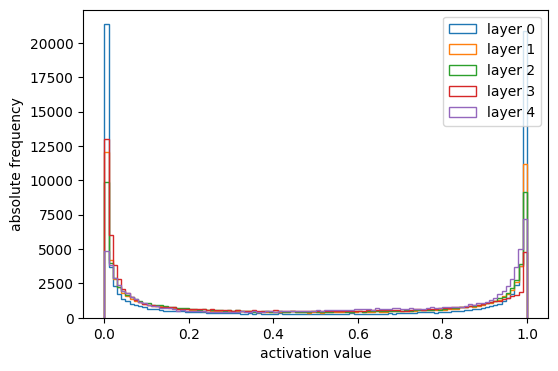

In [20]:
init_mode = 1 #Added to have the want weight init

#activations are saturated
num_samples = 1000
num_feat = 100
num_classes = 3
x_data = np.random.randn(num_samples, num_feat)
y_data = np.random.randint(0, num_classes, num_samples)

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_data, 'y_train' : y_data,  \
          'x_val' : x_data, 'y_val' : y_data}

#rate of 0.14 seems to be a good choice for CE-loss
rate = 0.14
batch_size=0

#create MLP (only one hidden layer)
mlp = MultiLayerPerceptron([num_feat, num_feat, num_feat, num_feat, num_feat, num_feat, num_classes], \
                           activation = 'sigmoid')

mlp.optimise(data, 1, rate, batch_size)

plot_activation_histogram()

## Test 2
Now extend the Dense Layer with the improved but non-optimal weight initialization as used by X. Glorot and J. Bengio in their first trial $\sqrt{2/(n_{in} + n_{out})}$ (Equation 10 in lecture notes). Perform a few training steps and convince yourself, that the variances of the activations decrease constantly throughout the neural net. The curves should look similar to Fig.6 top in http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf. Explain in a few words, why the variance decreases and by how much from layer to layer.

final result after 1 epochs, train: cost 1.09858, error 0.65600 ; validation: cost 1.09858, error 0.65600


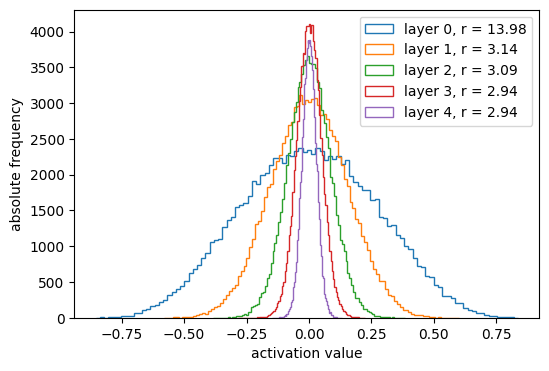

In [64]:
init_mode = 2 #Added to have the want weight init

#repeat findings of Glorot and Bengio: activations get smaller (factor 1/3 missing)
num_samples = 1000
num_feat = 100
num_classes = 3
#to avoid saturation in the first layer we choose a somewhat smaller standard deviation
stand_dev = 0.5
x_data = stand_dev*np.random.randn(num_samples, num_feat)
y_data = np.random.randint(0, num_classes, num_samples)

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_data, 'y_train' : y_data,  \
          'x_val' : x_data, 'y_val' : y_data}

#rate of 0.14 seems to be a good choice for CE-loss
rate = 0.14
batch_size=0

#create MLP (only one hidden layer)
mlp = MultiLayerPerceptron([num_feat, num_feat, num_feat, num_feat, num_feat, num_feat, num_classes], \
                           activation = 'tanh')

mlp.optimise(data, 1, rate, batch_size)

plot_activation_histogram(show_var_ratio=True)

## Test 3
Finally extend the Dense Layer with with proper *Xavier* weight initialization scheme i.e. $\sqrt{6/(n_{in} + n_{out})}$. Perform a few training steps and convince yourself, that the variances of the activations remain constant throughout the neural net. The curves should look similar to Fig.6 bottom in http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf.

final result after 1 epochs, train: cost 1.09811, error 0.60200 ; validation: cost 1.09811, error 0.60200


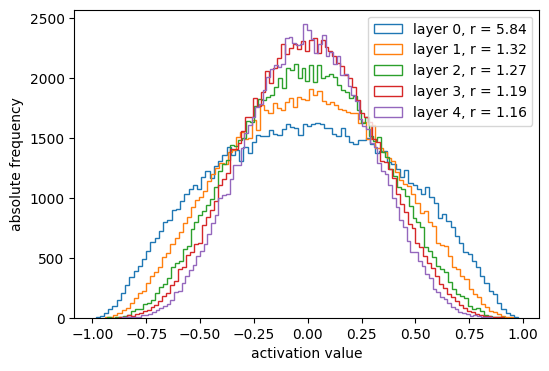

In [68]:
init_mode = 3 #Added to have the want weight init

#repeat findings of Glorot and Bengio: activations keep variance for correct weight initialization
num_samplpyplotes = 1000
num_feat = 100
num_classes = 3
#to avoid saturation in the first layer we choose a somewhat smaller standard deviation
stand_dev = 0.5
x_data = stand_dev*np.random.randn(num_samples, num_feat)
y_data = np.random.randint(0, num_classes, num_samples)

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_data, 'y_train' : y_data,  \
          'x_val' : x_data, 'y_val' : y_data}

#rate of 0.14 seems to be a good choice for CE-loss
rate = 0.14
batch_size=0

#create MLP (only one hidden layer)
mlp = MultiLayerPerceptron([num_feat, num_feat, num_feat, num_feat, num_feat, num_feat, num_classes], \
                           activation = 'tanh')

mlp.optimise(data, 1, rate, batch_size)

plot_activation_histogram(show_var_ratio=True)

### Test 4
Now again extend the Dense Layer with with weight initialization as used by X. Glorot and J. Bengio in their first trial $\sqrt{2/(n_{in} + n_{out})}$. Perform a few training steps using a layer architecture using a batch normalization layer after each dense layer and observe the variances throughout the neural net. Explain in a few words the behaviour observed and the benefits of the batch normalization layer.

final result after 1 epochs, train: cost 1.09299, error 0.58800 ; validation: cost 1.09299, error 0.58800


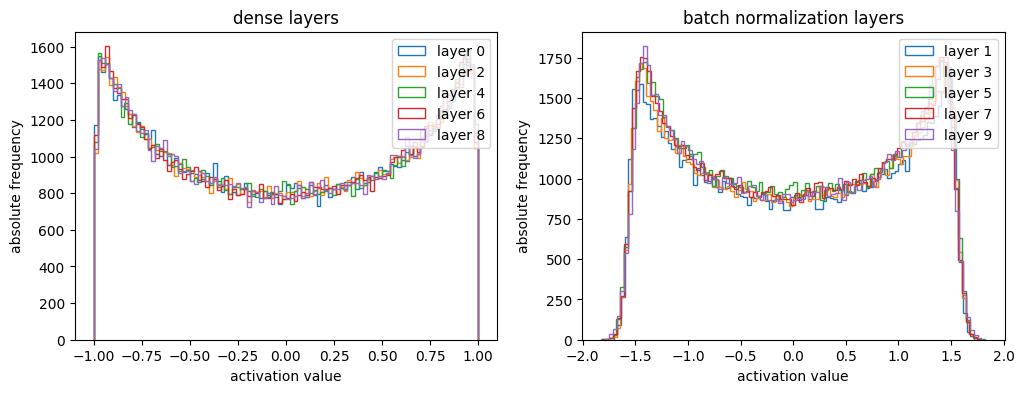

In [73]:
#batch normalization layer rescales the activations
num_samples = 1000
num_feat = 100
num_classes = 3
x_data = np.random.randn(num_samples, num_feat)
y_data = np.random.randint(0, num_classes, num_samples)

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_data, 'y_train' : y_data,  \
          'x_val' : x_data, 'y_val' : y_data}

#rate of 0.14 seems to be a good choice for CE-loss
rate = 0.14
batch_size=0

#create MLP (only one hidden layer)
mlp = MultiLayerPerceptron([num_feat, num_feat, num_feat, num_feat, num_feat, num_feat, num_classes], \
                           activation = 'tanh', batch_norm = True)

mlp.optimise(data, 1, rate, batch_size)
plot_activation_histogram_batch()

# Tests
### Test analytical value of derivative using backpropagation through comparison with difference quotient

#### Important ! Set the value of eps in the constructor of the BatchNormLayer to eps=1.0e-8
#### Otherwise, using the value of eps=1.0e-3 will introduce errors above the max_diff


In [24]:
#define set of m dummy samples with num_features features each being N(0,1) normalised
num_features = 50
m = 30
num_outcomes = 4
x_0 = np.random.randn(m, num_features)
y_0 = np.random.randint(0,num_outcomes,size=m)

#create a dummy MLP; num of input and output layers is fixed, hidden layers can be configured
mlp_0 = MultiLayerPerceptron([num_features, 50, 40, 30, num_outcomes], batch_norm = True)

#do propagation and backpropagation
#for test of batch normalization layer it is important to set training flag to true !!
y_pred = mlp_0.propagate(x_0, True)
dL_x = mlp_0.back_propagate(y_0)

L = mlp_0.cost_funct(y_pred, y_0)

#apply eps to given layer
eps = 1.0e-8
#maximum allowed difference
max_diff = 4.0e-5

#loop over all layers
layer_ind = 0
for layer in mlp_0.layers:
      
    #we assume that each dense layer is followed by a batch normaliation layer
    if np.mod(layer_ind, 2):
        print('test gammas for layer %r' % layer_ind)
        for i0 in range(layer.gamma.shape[1]):
            #add eps to gamma
            layer.gamma[0,i0] += eps
            #do propagation
            y_pred = mlp_0.propagate(x_0, True)
            #determine new cost function and ...
            L_eps = mlp_0.cost_funct(y_pred, y_0)
            #determine approx. derivative
            dL = (L_eps-L)/eps
            
            #compare this value to result from backpropagation
            if np.abs(dL - layer.dL_dgamma[0,i0]) > max_diff:
                print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dgamma[0,i0]))
            
            #set value back to original value
            layer.gamma[0,i0] -= eps
            
        print('test betas for layer %r' % layer_ind)
        for i0 in range(layer.beta.shape[1]):
            #add eps to beta
            layer.beta[0,i0] += eps
            #do propagation
            y_pred = mlp_0.propagate(x_0, True)
            #determine new cost function and ...
            L_eps = mlp_0.cost_funct(y_pred, y_0)
            #determine approx. derivative
            dL = (L_eps-L)/eps
            
            #compare this value to result from backpropagation
            if np.abs(dL - layer.dL_dbeta[0,i0]) > max_diff:
                print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dbeta[0,i0]))
            
            #set value back to original value
            layer.beta[0,i0] -= eps
    else:
        print('test weights W for layer %r' % layer_ind)
        #loop over all weights in layer
        for i0 in range(layer.W.shape[0]):
            for i1 in range(layer.W.shape[1]):
                #add eps to weight
                layer.W[i0,i1] += eps
                #do propagation
                y_pred = mlp_0.propagate(x_0, True)
                #determine new cost function and ...
                L_eps = mlp_0.cost_funct(y_pred, y_0)
                #determine approx. derivative
                dL = (L_eps-L)/eps

                #compare this value to result from backpropagation
                if np.abs(dL - layer.dL_dW[i0,i1]) > max_diff:
                    print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dW[i0,i1]))

                #set value back to original value
                layer.W[i0,i1] -= eps

        print('test bias B for layer %r' % layer_ind)
        #loop over all bias values in layer
        for i1 in range(layer.B.shape[1]):
            #add eps to weight
            layer.B[0,i1] += eps
            #do propagation
            y_pred = mlp_0.propagate(x_0, True)
            #determine new cost function and ...
            L_eps = mlp_0.cost_funct(y_pred, y_0)
            #determine approx. derivative
            dL = (L_eps-L)/eps

            #compare this value to result from backpropagation
            if np.abs(dL - layer.dL_dB[0,i1]) > max_diff:
                print('layer = %r, i0 = %r, i1 = %r, diff = %r' %(layer_ind, i0, i1, dL-layer.dL_dB[0,i1]))

            #set value back to original value
            layer.B[0,i1] -= eps
            
    layer_ind += 1

test weights W for layer 0
test bias B for layer 0
test gammas for layer 1
test betas for layer 1
test weights W for layer 2
test bias B for layer 2
test gammas for layer 3
test betas for layer 3
test weights W for layer 4
test bias B for layer 4
test gammas for layer 5
test betas for layer 5
test weights W for layer 6
test bias B for layer 6


# Unit Tests
### Unit Test for BatchNormLayer propagate
#### Important ! These tests use a value of eps in the constructor of the BatchNormLayer equal to eps=1.0e-3


In [33]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
batchNormLayer = BatchNormLayer(3,3)

#choose non-trivial values for gamma and beta 
batchNormLayer.gamma = np.array([[1.2, 0.3, -1.4]])
batchNormLayer.beta = np.array([[-0.2, 1.8, 0.4]])

#do propagation
y_pred = batchNormLayer.propagate(x_0, True)

#compare with expected result
y_exp = np.array([[-0.39284403,  1.54322612, -0.34042881],
       [-0.39284403,  1.75945676,  1.73277186],
       [ 1.66415895,  2.30003334, -1.52511491],
       [-1.67847089,  1.59728378,  1.73277186]]
)

mu_avg_exp = np.array([[ 0.275,  0.575, -0.55 ]])
sigma_avg_exp = np.array([[0.4656984 , 0.553963  , 0.47169906]])

np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=2)
np.testing.assert_array_almost_equal(batchNormLayer.mu_avg,mu_avg_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.sigma_avg,sigma_avg_exp,decimal=2)

### Unit Test for BatchNormLayer back_propagate
Assumes that Unit Test for propagate is correct¶

In [32]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
batchNormLayer = BatchNormLayer(3,3)

#choose non-trivial values for gamma and beta 
batchNormLayer.gamma = np.array([[1.2, 0.3, -1.4]])
batchNormLayer.beta = np.array([[-0.2, 1.8, 0.4]])

#do propagation
y_pred = batchNormLayer.propagate(x_0, True)
dL_da = batchNormLayer.back_propagate(y_pred)

dL_dbeta_exp = np.array([[-0.2, 1.8, 0.4]])
dL_dgamma_exp = np.array([[ 1.194863  ,  0.29891982, -1.39408284]])
dL_da_exp = np.array([[-2.12265436e-03, -4.99784266e-04,  9.26855963e-03],
       [-2.12265436e-03, -7.89133052e-05, -1.66834073e-02],
       [ 2.05189921e-02,  9.73264097e-04,  2.40982550e-02],
       [-1.62736834e-02, -3.94566526e-04, -1.66834073e-02]])

print(dL_da)

np.testing.assert_array_almost_equal(dL_da,dL_da_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dbeta,dL_dbeta_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dgamma,dL_dgamma_exp,decimal=2)

[[-0.66921341  2.2614505   0.87433952]
 [-0.66921341  2.32612043 -2.01479548]
 [ 1.78747949  2.48779525  2.52527381]
 [-2.20464647  2.27761798 -2.01479548]]


AssertionError: 
Arrays are not almost equal to 8 decimals

Mismatched elements: 12 / 12 (100%)
Max absolute difference: 2.50117555
Max relative difference: 29477.91044168
 x: array([[-0.66921341,  2.2614505 ,  0.87433952],
       [-0.66921341,  2.32612043, -2.01479548],
       [ 1.78747949,  2.48779525,  2.52527381],
       [-2.20464647,  2.27761798, -2.01479548]])
 y: array([[-2.12265436e-03, -4.99784266e-04,  9.26855963e-03],
       [-2.12265436e-03, -7.89133052e-05, -1.66834073e-02],
       [ 2.05189921e-02,  9.73264097e-04,  2.40982550e-02],
       [-1.62736834e-02, -3.94566526e-04, -1.66834073e-02]])